In [1]:
from bs4 import BeautifulSoup
import nbformat
from nbformat.v4 import output_from_msg
from nbconvert.preprocessors import ExecutePreprocessor
import markdown

# Lire le notebook
with open("Projet 5 Notebook Simulation.ipynb") as f:
    nb = nbformat.read(f, as_version=4)

# Récupérer le contenu Markdown des cellules
md_content = ""
for cell in nb.cells:
    if cell.cell_type == "markdown":
        md_content += cell.source + "\n"

# Parser le contenu Markdown pour extraire les titres
html_content = markdown.markdown(md_content)
title_tags = ["h1", "h2", "h3", "h4", "h5", "h6"]
titles = [t.text for t in BeautifulSoup(html_content, "html.parser").find_all(title_tags)]

# Afficher les titres et créer un sommaire
print("Titres :")
for title in titles:
    print(title)

print("Sommaire :")
for i, title in enumerate(titles):
    print(f"{i+1}. {title}")


Titres :
Importation des jeux de données
Sommaire :
1. Importation des jeux de données


# Importation des librairies

In [2]:
# importation des librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import adjusted_rand_score

In [3]:
#réglage de l'affichage de données
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 70)
pd.set_option('display.precision', 5)

In [4]:
def scores_ari(period_name, datetime):

    #data_year = df_data[df_data['last_purchase'] < pd.to_datetime('2018-01-05')]
    data_year = data[data['order_purchase_timestamp'] < pd.to_datetime(datetime)]
    data_year = data_year.drop(['order_purchase_timestamp'], axis=1)
    data_year_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(data_year), columns=data_year.columns,
                                    index=data_year.index)

    kmeans_maintenance = KMeans(init='k-means++', n_clusters=7, n_init=10, random_state=42)
    kmeans_maintenance.fit(data_year_scaled)
    print(kmeans_maintenance.fit(data_year_scaled).labels_)


    # Création d'une liste vide pour stocker les scores ARI calculés pour chaque période
    df_scores = []

    # Détermination de la longueur du vecteur de labels kmeans_maintenance.labels_
    length = len(kmeans_maintenance.labels_) - 1

    # Boucle sur chaque période
    for i in range(len(period_name)):
        # Initialisation d'un dictionnaire pour stocker les scores pour la période actuelle
        scores = {}

        # Sélection des données de formation jusqu'à la date de fin de la période actuelle
        df = data[data['order_purchase_timestamp'] < pd.to_datetime(period_name[i])]

        # Suppression de la colonne 'order_purchase_timestamp'
        df = df.drop(['order_purchase_timestamp'], axis=1)

        # Normalisation des données en utilisant le StandardScaler
        df_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df),
                                 columns=df.columns,
                                 index=df.index)

        # Initialisation d'un modèle KMeans avec 7 clusters
        kmeans_model = KMeans(init='k-means++', n_clusters=7, n_init=10, random_state=42)

        # Ajustement du modèle KMeans aux données de la periode de maintenance (data_year_scaled)
        kmeans_model.fit(data_year_scaled)

        # Prédiction des clusters pour les données de la période actuelle avant l'ajustement du modèle
        clusters_before = kmeans_model.predict(df_scaled)

        # Ajustement du modèle KMeans aux données de la période actuelle
        model_fit_df = kmeans_model.fit(df_scaled)

        # Prédiction des clusters pour les données de la période actuelle après l'ajustement du modèle
        clusters_after = model_fit_df.predict(df_scaled)

        # Calcul du score ARI pour les clusters avant et après l'ajustement du modèle
        ari_score = round(adjusted_rand_score(
            clusters_before[0:length],
            clusters_after[0:length]), 2)

        # Ajout des scores pour la période actuelle au dictionnaire scores
        scores['period'] = str(i + 1) + ' mois'
        scores['ari_score'] = ari_score

        # Ajout du dictionnaire scores à la liste df_scores
        df_scores.append(scores)

    # Création de la figure avec une taille personnalisée
    fig = plt.figure(figsize=(20, 8))

    # Création du graphique à l'aide de la fonction lineplot
    bp = sn.lineplot(
        y='ari_score',
        x='period',
        data=pd.DataFrame(
            df_scores,
            columns=['period', 'ari_score'],
        ),
        color='green',  # modification de la couleur de la ligne
        linestyle='dashed',  # modification du style de la ligne
        ci=None)

    # Ajout des annotations de valeurs sur les points
    for p in bp.patches:
        bp.annotate(format(p.get_height(), '.1f'),
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 8),
                    textcoords='offset points')

    # Définition des labels des axes X et Y
    plt.xlabel('Période')
    plt.ylabel('Score ARI')

    # Définition de la plage de l'axe Y
    plt.ylim(0.0, 1.0)

    # Ajout d'un titre au graphique
    plt.title('Évolution du score ARI en fonction des périodes')

    # Affichage du graphique
    plt.show()

In [5]:
def standard_scaler(df):
    ss = preprocessing.StandardScaler()
    numerical_columns = df.select_dtypes(['float64','int64']).columns
    #df[numerical_columns] = df[numerical_columns].apply(np.log1p, axis=1)
    for col in numerical_columns:
        df[numerical_columns] = ss.fit_transform(df[numerical_columns])
    return df

## Importation des jeux de données

In [6]:
#Importation du jeu de données d'entrainement
missing_values = ["n/a", "na", "--", "nan", "NaN"]
data = pd.read_csv('df_final.csv', decimal=".", index_col=0, encoding='utf_8', low_memory=False,
                         na_values=missing_values).reset_index()

In [7]:
#Importation du jeu de données de test
missing_values = ["n/a", "na", "--", "nan", "NaN"]
test_data = pd.read_csv('fr_data_test.csv', decimal=".", index_col=0, encoding='utf_8', low_memory=False,
                   na_values=missing_values).reset_index()

In [8]:
data

,price,payment_type_boleto,payment_type_credit_card,review_score_1.0,review_score_3.0,review_score_4.0,review_score_5.0,payment_installments_1.0,payment_installments_2.0,nb_articles_1,nb_articles_2,order_purchase_timestamp
0,-1.22718,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2017-10-12
1,0.94496,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2017-11-14
2,0.78409,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2018-04-05
3,-1.13731,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2018-04-20
4,1.00546,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2018-02-28
...,...,...,...,...,...,...,...,...,...,...,...,...
64062,-0.57321,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2018-08-15
64063,-0.15137,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2017-10-30
64064,-0.28051,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2017-12-17
64065,2.21559,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2017-06-08


In [9]:
test_data

,customer_unique_id,customer_zip_code_prefix,city,customer_state,order_purchase_timestamp,payment_value,payment_type,payment_installments,review_score,price,product_category_name,order_purchase_hour,order_purchase_time_day,order_purchase_dayofweek,nb_articles
0,fdb2bb535d1241519a4c88b74b9e1dc2,64074,teresina,PI,2018-07-23,235.23,credit_card,3.0,5.0,128.00,costruction_tools_garden,10,Nuit,Mon,1
1,3f674fe4ac8e1484400c756eabdff69a,84920,japira,PR,2018-03-04,211.92,boleto,1.0,4.0,88.90,hygiene_and_beauty,23,Nuit,Sun,2
2,f877af6e86082056ebb09008e563de9a,12517,guaratingueta,SP,2017-03-16,150.72,boleto,1.0,5.0,136.00,hygiene_and_beauty,20,Soiree,Thu,1
3,cd0e1d42225b7f4cf78a382e4f57e704,4719,sao paulo,SP,2018-06-24,317.40,credit_card,1.0,4.0,300.00,tools,11,Nuit,Sun,1
4,8338340a8f7154c52932012830e0f7d9,5596,sao paulo,SP,2017-08-06,326.78,credit_card,1.0,4.0,150.00,electronics,20,Soiree,Sun,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30918,e9b0b94dbd472812c6d5cfe014ab7a96,36900,manhuacu,MG,2017-04-04,151.48,credit_card,6.0,4.0,63.90,decoration,22,Soiree,Tue,2
30919,091d7f5b87a837d9b5790109b63ff1ac,86465,guapirama,PR,2017-05-16,100.00,voucher,1.0,5.0,89.90,decoration,14,Midi,Tue,2
30920,6682581c8fa800c2b0de2b735bb07a5e,49130,riachuelo,SE,2018-08-16,90.97,credit_card,4.0,4.0,39.97,decoration,6,Nuit,Thu,1
30921,400028a363e9857f1e56833f2be713a5,22780,rio de janeiro,RJ,2018-05-04,247.22,credit_card,8.0,5.0,199.00,other,18,Apres Midi,Fri,1


In [10]:
# Conversion de la feature au format datetime
data['order_purchase_timestamp'] = pd.to_datetime(
    data['order_purchase_timestamp'])

In [11]:
debut_periode = data['order_purchase_timestamp'].min()  # commande la plus ancienne :  2016-10-03 12:16:38
fin_periode = data['order_purchase_timestamp'].max()  # commande la plus récente  :  2018-08-29 17:40:06

data['order_purchase_timestamp'] = data['order_purchase_timestamp'].dt.date  # enlève les heures, minutes, secondes

# orders['date'] = pd.to_datetime(orders['date'])   # object >> datetime64

print("Commande la plus récente  :", fin_periode)
print("Commande la plus ancienne :", debut_periode)

Commande la plus récente  : 2018-08-29 00:00:00
Commande la plus ancienne : 2016-10-04 00:00:00


In [12]:
data.order_purchase_timestamp = data.order_purchase_timestamp.apply(pd.to_datetime, format='%Y-%m-%d')

In [13]:
data.columns

Index(['price', 'payment_type_boleto', 'payment_type_credit_card',
       'review_score_1.0', 'review_score_3.0', 'review_score_4.0',
       'review_score_5.0', 'payment_installments_1.0',
       'payment_installments_2.0', 'nb_articles_1', 'nb_articles_2',
       'order_purchase_timestamp'],
      dtype='object')

In [14]:
# Select the features to use for clustering
features = ['price', 'payment_type_boleto', 'payment_type_credit_card',
            'review_score_1.0', 'review_score_3.0', 'review_score_4.0',
            'review_score_5.0', 'payment_installments_1.0',
            'payment_installments_2.0', 'nb_articles_1', 'nb_articles_2']

In [15]:
# Instantiate and fit a KMeans model on the training data
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data[features])

/Users/xparisot/opt/anaconda3/envs/ProjectOPC/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(random_state=42)

In [16]:
period1 = [
    '2016-11-03',
    '2016-12-03',
    '2017-01-03',
    '2017-02-03',
    '2017-03-03',
    '2017-04-03',
    '2017-05-03',
    '2017-06-03',
    '2017-07-03',
    '2017-08-03',
    '2017-09-03',
    '2017-10-03',
    '2017-11-03',
    '2017-12-03',
    '2018-01-03',
    '2018-02-03',
    '2018-03-03',
    '2018-04-03',
    '2018-05-03',
    '2018-06-03',
    '2018-07-03',
    '2018-08-03'
]

/var/folders/2h/0h36_vhs46g36p7g0wcsfpc40000gn/T/ipykernel_7543/1074960357.py:10: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  kmeans_maintenance.fit(data_year_scaled)
/var/folders/2h/0h36_vhs46g36p7g0wcsfpc40000gn/T/ipykernel_7543/1074960357.py:11: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  print(kmeans_maintenance.fit(data_year_scaled).labels_)


[2 5 4 1 1 3 0]


/var/folders/2h/0h36_vhs46g36p7g0wcsfpc40000gn/T/ipykernel_7543/1074960357.py:40: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  kmeans_model.fit(data_year_scaled)
/var/folders/2h/0h36_vhs46g36p7g0wcsfpc40000gn/T/ipykernel_7543/1074960357.py:46: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  model_fit_df = kmeans_model.fit(df_scaled)
/var/folders/2h/0h36_vhs46g36p7g0wcsfpc40000gn/T/ipykernel_7543/1074960357.py:40: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  kmeans_model.fit(data_year_scaled)
/var/folders/2h/0h36_vhs46g36p7g0wcsfpc40000gn/T/ipykernel_7543/1074960357.py:46: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  model_fit_df = kmeans_model.fit(df_scaled)
/var

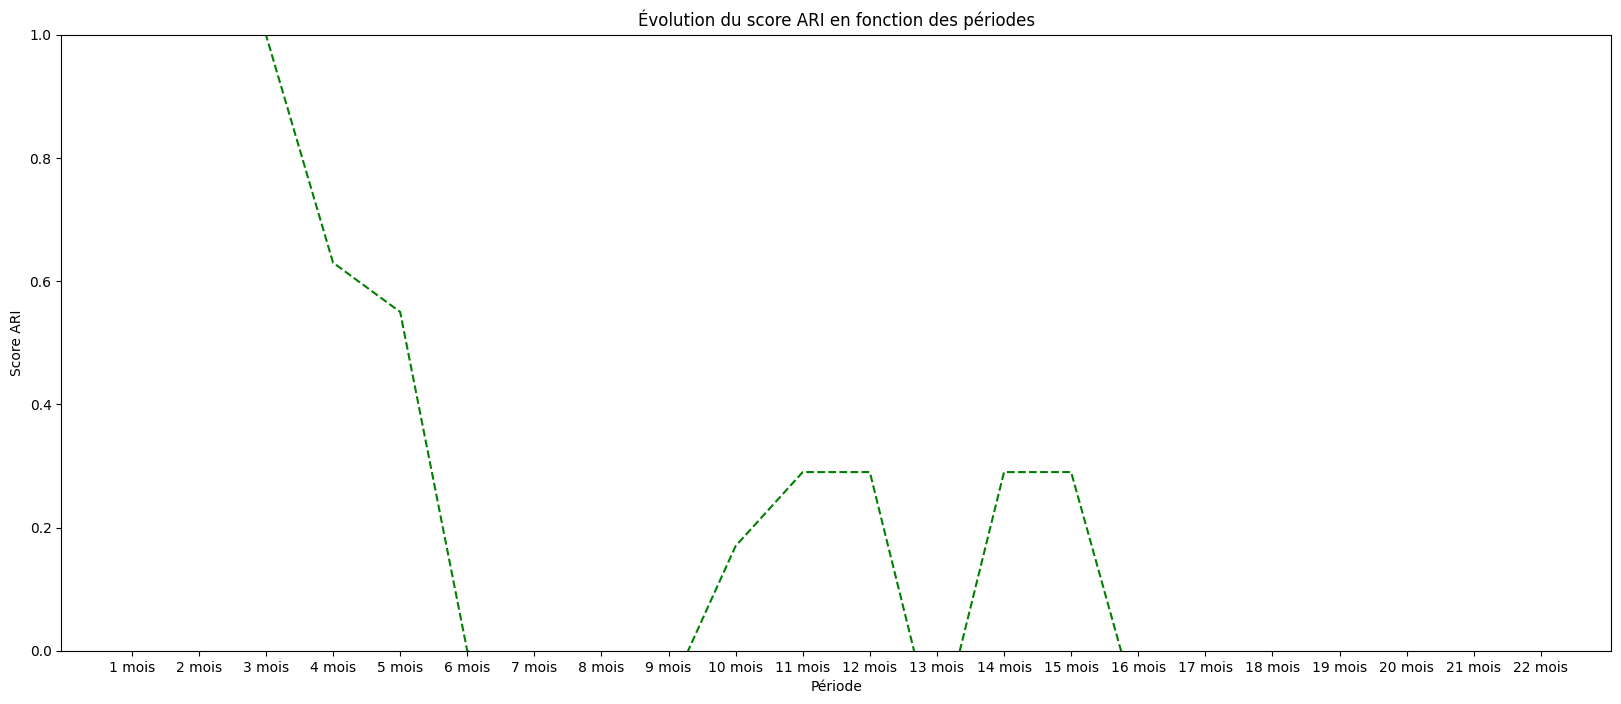

In [24]:
scores_ari(period1, '2017-01-03')


Au bout de 3 mois la dégradation commence pour être a son maximum au bout de 6 mois. 
Un contrat de maintenance tous les 3 mois semble être le plus adapté. 

